In [1]:
# whm
import scipy.io
import torch
import torch.nn as nn
from kymatio import Scattering2D
import matplotlib.pyplot as plt
from skimage.transform import resize
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils import data
import numpy as np


# Data loading

## parameters

In [2]:
batch_size = 4
val_percentage = 0.2


## data loading for scattering net

In [3]:
# dataset for scattering net
train_dataset_scattering_net = datasets.MNIST('./data_project1', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
val_dataset_scattering_net = datasets.MNIST('./data_project1', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
test_dataset_scattering_net = datasets.MNIST('./data_project1', train=False, transform=transforms.Compose([
        transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
# split train and validation
num_all = len(train_dataset_scattering_net)
num_val = int(val_percentage * num_all)
num_train = num_all - num_val
num_test = len(test_dataset_scattering_net)
indexes = list(range(num_all))
np.random.shuffle(indexes)
train_indexes, val_indexes = indexes[:-num_val], indexes[num_val:]
train_sub, val_sub = data.sampler.SubsetRandomSampler(train_indexes), data.sampler.SubsetRandomSampler(val_indexes)

# data loader for scattering net
train_loader_scattering_net = data.DataLoader(train_dataset_scattering_net, batch_size=batch_size, sampler = train_sub, num_workers =8)
val_loader_scattering_net = data.DataLoader(val_dataset_scattering_net, batch_size=batch_size, sampler = val_sub, num_workers =8)
test_loader_scattering_net = data.DataLoader(test_dataset_scattering_net, batch_size=batch_size, num_workers =8)

## data loading for resnet18

In [4]:
# dataset for resnet18
train_dataset_resnet18 = datasets.MNIST('./data_project1', train=True, download=True,
                   transform=transforms.Compose([transforms.Grayscale(3),transforms.Resize(224),
                       transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
val_dataset_resnet18 = datasets.MNIST('./data_project1', train=True, download=True,
                   transform=transforms.Compose([transforms.Grayscale(3),transforms.Resize(224),
                       transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_dataset_resnet18 = datasets.MNIST('./data_project1', train=False, transform=transforms.Compose([transforms.Grayscale(3), transforms.Resize(224),
        transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

# data loader for resnet18
train_loader_resnet = data.DataLoader(train_dataset_resnet18, batch_size=batch_size, sampler = train_sub, num_workers =8)
val_loader_resnet = data.DataLoader(val_dataset_resnet18, batch_size=batch_size, sampler = val_sub, num_workers =8)
test_loader_resnet = data.DataLoader(test_dataset_resnet18, batch_size=batch_size, num_workers =8)


# Feature extraction by scattering net with known invariants

In [5]:
from kymatio import Scattering2D
scattering = Scattering2D(shape=(28, 28), J=2)
scattering.cuda()
features_scattering_net = np.zeros([num_train, 81 * 7 * 7])
labels_scattering = np.zeros([num_train])
for batch_id, (images, labels)  in enumerate(train_loader_scattering_net):
    images, labels = images.cuda(), labels.cuda()
    num_samples_batch = images.shape[0]
    features_scattering_net[batch_id * batch_size: min((batch_id + 1) * batch_size, num_train)] = scattering(images).reshape([num_samples_batch,-1]).cpu()
    labels_scattering[batch_id * batch_size: min((batch_id + 1) * batch_size, num_train)] = labels.cpu()


/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [6]:
"""
num_samples_batch = images.shape[0]
print(num_samples_batch)
scattering(images).reshape([num_samples_batch,-1]).shape
"""
print(features_scattering_net.shape)
print(labels.shape)
print(labels_scattering.shape)


(48000, 3969)
torch.Size([4])
(48000,)


# Feature extraction by pre-trained deep neural networks resnet18

In [7]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential()
resnet18.cuda()
features_resnet18 = np.zeros([num_train, 512])
labels_resnet18 = np.zeros([num_train])

for batch_id, (images, labels)  in enumerate(train_loader_resnet):
    images, labels = images.cuda(), labels.cuda()
    features_resnet18[batch_id * batch_size: min((batch_id + 1) * batch_size, num_train)] = resnet18(images).cpu().detach().numpy()
    labels_resnet18[batch_id * batch_size: min((batch_id + 1) * batch_size, num_train)] = labels.cpu().detach().numpy()


In [8]:

"""print(images.shape)
resnet18 = models.resnet18(pretrained=True)
resnet18(images)"""
print(features_resnet18.shape)
print(labels_resnet18.shape)

(48000, 512)
(48000,)


# Visualize these features using classical unsupervised learning methods, e.g. PCA/MDS, Manifold Learning, t-SNE,

In [9]:
def visualization(vis_feature, labels, title):
    import matplotlib.pyplot as plt
    targets = range(10)
    targets_str = list(map(lambda x: 'digit' + str(x), targets))
    cmap = plt.cm.get_cmap('hsv', 10)
    colors = []
    for c_index in range(10):
        colors.append(np.array(cmap(c_index)).reshape([1,-1]))
    """cmap = plt.cm.get_cmap('hsv', 10)
    colors = []
    for c_index in range(10):
        colors.append(cmap(c_index))
    print(colors)"""
    fig = plt.figure(figsize = (18,8))

    ### visualization of features extracted by scattering net using PCA
    ax1 = fig.add_subplot(1,1,1) 
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')
    ax1.set_title(title)

    for target, color in zip(targets,colors):
        indicesToKeep = labels == target    
        ax1.scatter(vis_feature[indicesToKeep, 0]
                   , vis_feature[indicesToKeep, 1]
                   , c = color
                   , alpha = 0.3                
                   , s = 10)
    ax1.legend(targets_str)

## PCA decomposition

In [10]:
from sklearn.decomposition import PCA
vis_PCA_of_scattering_net = PCA(n_components=2).fit_transform(features_scattering_net)  
vis_PCA_of_resnet18 = PCA(n_components=2).fit_transform(features_resnet18)  
print(vis_PCA_of_scattering_net.shape)
print(vis_PCA_of_resnet18.shape)



(48000, 2)
(48000, 2)


##  Visualization using PCA

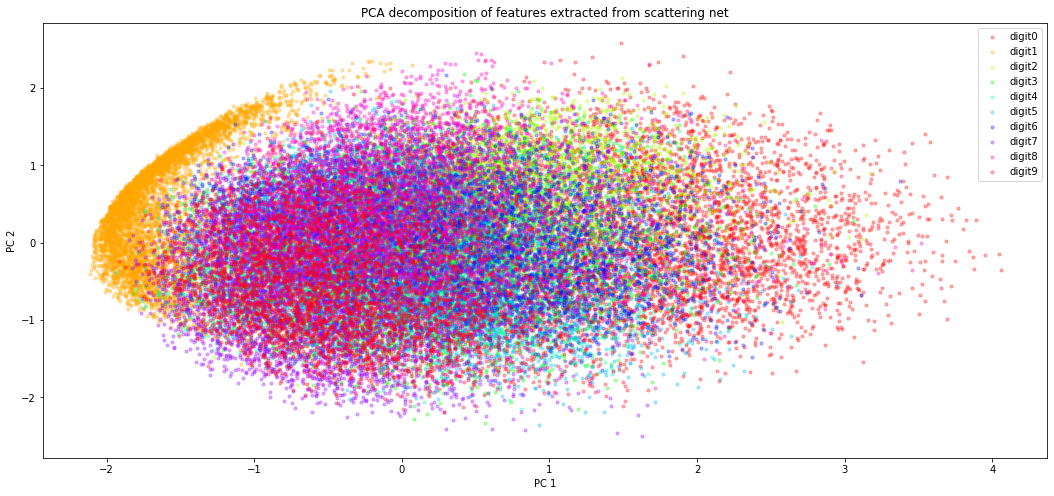

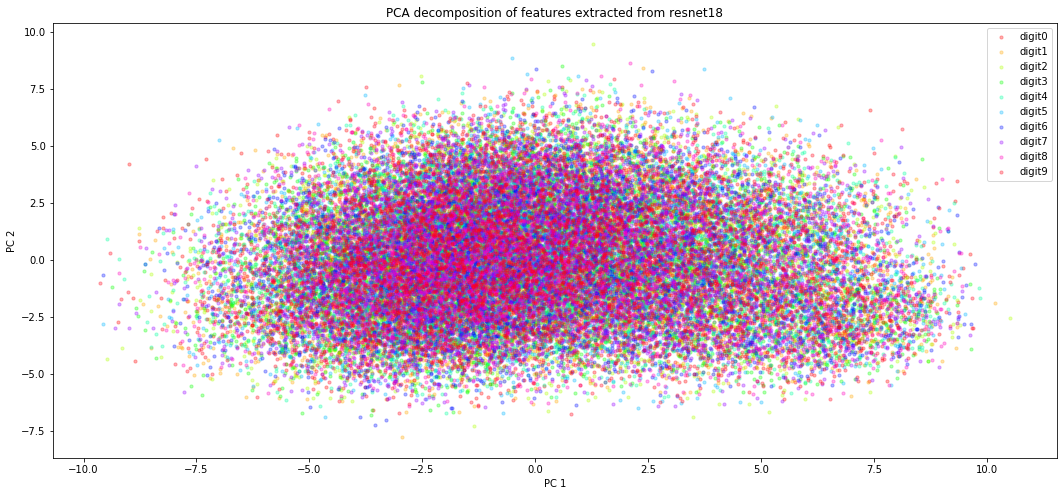

In [11]:
visualization(vis_PCA_of_scattering_net,labels_scattering, 'PCA decomposition of features extracted from scattering net')
visualization(vis_PCA_of_resnet18,labels_scattering, 'PCA decomposition of features extracted from resnet18')

In [12]:
### reference: https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb
"""
import matplotlib.pyplot as plt
targets = range(10)
targets_str = list(map(lambda x: 'digit' + str(x), targets))
cmap = plt.cm.get_cmap('hsv', 10)
colors = []
for c_index in range(10):
    colors.append(np.array(cmap(c_index)).reshape([1,-1]))
fig = plt.figure(figsize = (18,8))

### visualization of features extracted by scattering net using PCA
ax1 = fig.add_subplot(1,2,1) 
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_title('PCA decomposition of features extracted from scattering net')

for target, color in zip(targets,colors):
    indicesToKeep = labels_scattering == target    
    ax1.scatter(vis_PCA_of_scattering_net[indicesToKeep, 0]
               , vis_PCA_of_scattering_net[indicesToKeep, 1]
               , c = color
               , alpha = 0.3                
               , s = 10)
ax1.legend(targets_str)
### visualization of features extracted by resnet18 using PCA
ax2 = fig.add_subplot(1,2,2) 
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title('PCA decomposition of features extracted from resnet18')

for target, color in zip(targets,colors):
    indicesToKeep = labels_scattering == target    
    ax2.scatter(vis_PCA_of_resnet18[indicesToKeep, 0]
               , vis_PCA_of_resnet18[indicesToKeep, 1]
               , c = color
               , alpha = 0.3                
               , s = 10)
ax2.legend(targets_str)
"""



"\nimport matplotlib.pyplot as plt\ntargets = range(10)\ntargets_str = list(map(lambda x: 'digit' + str(x), targets))\ncmap = plt.cm.get_cmap('hsv', 10)\ncolors = []\nfor c_index in range(10):\n    colors.append(np.array(cmap(c_index)).reshape([1,-1]))\nfig = plt.figure(figsize = (18,8))\n\n### visualization of features extracted by scattering net using PCA\nax1 = fig.add_subplot(1,2,1) \nax1.set_xlabel('PC 1')\nax1.set_ylabel('PC 2')\nax1.set_title('PCA decomposition of features extracted from scattering net')\n\nfor target, color in zip(targets,colors):\n    indicesToKeep = labels_scattering == target    \n    ax1.scatter(vis_PCA_of_scattering_net[indicesToKeep, 0]\n               , vis_PCA_of_scattering_net[indicesToKeep, 1]\n               , c = color\n               , alpha = 0.3                \n               , s = 10)\nax1.legend(targets_str)\n### visualization of features extracted by resnet18 using PCA\nax2 = fig.add_subplot(1,2,2) \nax2.set_xlabel('PC 1')\nax2.set_ylabel('PC

In [13]:
print('hee')

hee


##  t-SNE

In [14]:
import time
from sklearn.manifold import TSNE
start = time.time()
num_vis_t_SNE = features_scattering_net.shape[0]
vis_TSNE_of_scattering_net = TSNE(n_components=2).fit_transform(features_scattering_net[:num_vis_t_SNE])  
vis_TSNE_of_resnet18 = TSNE(n_components=2).fit_transform(features_resnet18[:num_vis_t_SNE])
end = time.time()
print('t-SNE takes {} seconds'.format(end - start))

t-SNE takes 13928.007472991943 seconds


##  Visualization using t-SNE

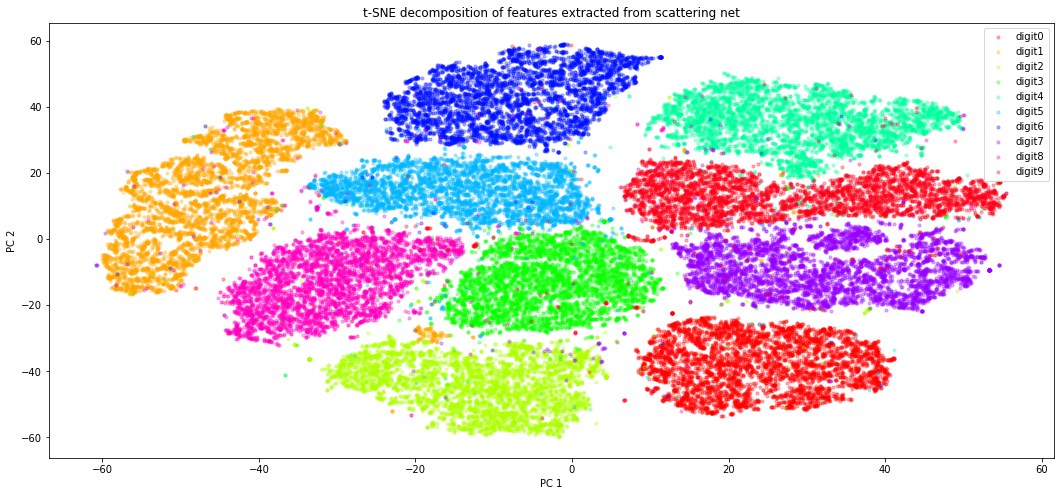

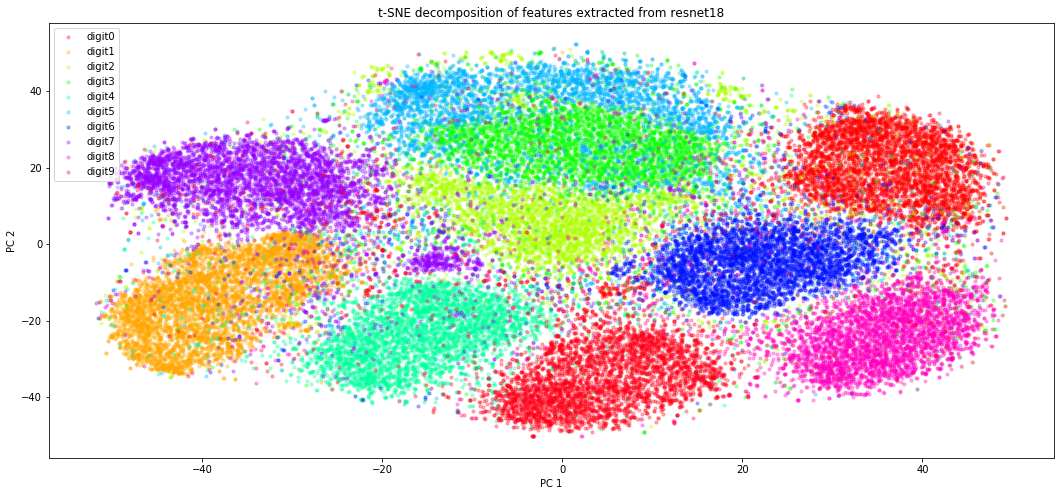

In [15]:
visualization(vis_TSNE_of_scattering_net, labels_scattering[:num_vis_t_SNE],'t-SNE decomposition of features extracted from scattering net')
visualization(vis_TSNE_of_resnet18,labels_resnet18[:num_vis_t_SNE], 't-SNE decomposition of features extracted from resnet18')

# Compute the global mean, class-means, etc. of features 

In [16]:
"""from sklearn.metrics.pairwise import cosine_similarity as cs
C = 10

global_mean_scattering_net_features = np.mean(features_scattering_net, axis = 0)
print('global mean:')
print()
# inner_class_scattering_net_features = []
class_mean_scattering_net_features = []
total_covariance_matrix_scattering_net_features_all = []
within_class_covariance_matrix_scattering_net_features_all = []
diff_all = []
for i in range(C):
    inner_class_scattering_net_features_each = features_scattering_net[labels_scattering == i]
    # mu_c
    class_mean_scattering_net_features_each = np.mean(inner_class_scattering_net_features_each, axis=0)
    class_mean_scattering_net_features.append(class_mean_scattering_net_features_each)
    # sigma_T_c
    total_covariance_matrix_scattering_net_features_each = np.cov(inner_class_scattering_net_features_each - global_mean_scattering_net_features, rowvar=False) # shape: feature_size * feature_size
    total_covariance_matrix_scattering_net_features_all.append(total_covariance_matrix_scattering_net_features_each)
    # sigma_W_c
    within_class_covariance_matrix_scattering_net_features_each = np.cov(inner_class_scattering_net_features_each - class_mean_scattering_net_features_each, rowvar=False) # shape: feature_size * feature_size
    within_class_covariance_matrix_scattering_net_features_all.append(within_class_covariance_matrix_scattering_net_features_each)
    # 
    diff_each = class_mean_scattering_net_features_each - global_mean_scattering_net_features
    diff_all.append(diff_each)
    
class_mean_scattering_net_features = np.array(class_mean_scattering_net_features)
# sigma_T
total_covariance_matrix_scattering_net_features_all = np.array(total_covariance_matrix_scattering_net_features_all)
total_covariance_matrix_scattering_net_features = np.mean(total_covariance_matrix_scattering_net_features_all, axis = 0)
# sigma_W
within_class_covariance_matrix_scattering_net_features_all = np.array(within_class_covariance_matrix_scattering_net_features_all)
within_class_covariance_matrix_scattering_net_features = np.mean(within_class_covariance_matrix_scattering_net_features_all, axis=0)
# sigma_B
between_class_variance_scattering_net_features = np.cov(class_mean_scattering_net_features - global_mean_scattering_net_features, rowvar=False)
# NC1
NC1 = np.trace(np.dot(within_class_covariance_matrix_scattering_net_features, np.conj(between_class_variance_scattering_net_features))) / C
diff = np.array(diff_all)
# closeness to maximal angle equiangularity
sqrt_norm_diff = np.sqrt(np.linalg.norm(diff, axis = 1))
closeness = np.std(sqrt_norm_diff) / np.mean(sqrt_norm_diff)
# equal_angularity
cosine_matrix = np.zeros([C, C])
for i in range(C):
    for j in range(C):
        cosine_matrix[i, j] = cs(diff[i].reshape([1, -1]), diff[j].reshape([1, -1]))
equal_angularity = np.std(cosine_matrix)
# closeness to maximal-angle equiangularity
closeness_max_ang_eq = np.mean(cosine_matrix + 1/(C - 1))
"""

"from sklearn.metrics.pairwise import cosine_similarity as cs\nC = 10\n\nglobal_mean_scattering_net_features = np.mean(features_scattering_net, axis = 0)\nprint('global mean:')\nprint()\n# inner_class_scattering_net_features = []\nclass_mean_scattering_net_features = []\ntotal_covariance_matrix_scattering_net_features_all = []\nwithin_class_covariance_matrix_scattering_net_features_all = []\ndiff_all = []\nfor i in range(C):\n    inner_class_scattering_net_features_each = features_scattering_net[labels_scattering == i]\n    # mu_c\n    class_mean_scattering_net_features_each = np.mean(inner_class_scattering_net_features_each, axis=0)\n    class_mean_scattering_net_features.append(class_mean_scattering_net_features_each)\n    # sigma_T_c\n    total_covariance_matrix_scattering_net_features_each = np.cov(inner_class_scattering_net_features_each - global_mean_scattering_net_features, rowvar=False) # shape: feature_size * feature_size\n    total_covariance_matrix_scattering_net_features_al

In [17]:
def statistics(features, labels, pendix):
    from sklearn.metrics.pairwise import cosine_similarity as cs
    C = 10

    global_mean = np.mean(features, axis = 0)
    print('global mean with :'.format(pendix))
    print(global_mean)
    # inner_class_scattering_net_features = []
    class_mean = []
    total_covariance_matrix_all = []
    within_class_covariance_matrix_all = []
    diff_all = []
    for i in range(C):
        inner_class_each = features[labels_scattering == i]
        # mu_c
        class_mean_each = np.mean(inner_class_each, axis=0)
        print('class mean of class {} with {}'.format(i, pendix))
        print(class_mean_each)
        class_mean.append(class_mean_each)
        # sigma_T_c
        total_covariance_matrix_each = np.cov(inner_class_each - global_mean, rowvar=False) # shape: feature_size * feature_size
        total_covariance_matrix_all.append(total_covariance_matrix_each)
        # sigma_W_c
        within_class_covariance_matrix_each = np.cov(inner_class_each - class_mean_each, rowvar=False) # shape: feature_size * feature_size
        within_class_covariance_matrix_all.append(within_class_covariance_matrix_each)
        # 
        diff_each = class_mean_each - global_mean
        diff_all.append(diff_each)

    class_mean = np.array(class_mean)
    # sigma_T
    total_covariance_matrix_all = np.array(total_covariance_matrix_all)
    total_covariance_matrix = np.mean(total_covariance_matrix_all, axis = 0)
    print('total covariance with {}'.format(pendix))
    print(total_covariance_matrix)
    # sigma_W
    within_class_covariance_matrix_all = np.array(within_class_covariance_matrix_all)
    within_class_covariance_matrix = np.mean(within_class_covariance_matrix_all, axis=0)
    print('within class covariance with {}'.format(pendix))
    print(within_class_covariance_matrix)
    # sigma_B
    between_class_variance = np.cov(class_mean - global_mean, rowvar=False)
    print('between class covariance with {}'.format(pendix))
    print(between_class_variance)
    # NC1
    NC1 = np.trace(np.dot(within_class_covariance_matrix, np.conj(between_class_variance))) / C
    print('NC1 with {}'.format(pendix))
    print(NC1)
    diff = np.array(diff_all)
    # closeness to equal-norms of class-means
    sqrt_norm_diff = np.sqrt(np.linalg.norm(diff, axis = 1))
    closeness = np.std(sqrt_norm_diff) / np.mean(sqrt_norm_diff)
    print('equal-norms of class-means with {}'.format(pendix))
    print(closeness)
    
    # equal_angularity
    cosine_matrix = np.zeros([C, C])
    for i in range(C):
        for j in range(C):
            cosine_matrix[i, j] = cs(diff[i].reshape([1, -1]), diff[j].reshape([1, -1]))
    equal_angularity = np.std(cosine_matrix)
    print('equal-angularity with {}'.format(pendix))
    print(equal_angularity)
    # closeness to maximal-angle equiangularity
    closeness_max_ang_eq = np.mean(cosine_matrix + 1/(C - 1))
    print('closeness to maximal-angle equiangularity {}'.format(pendix))
    print(closeness_max_ang_eq)


In [18]:
statistics(features_scattering_net, labels_scattering, 'feature extracted from scattering net')
statistics(features_resnet18, labels_resnet18, 'feature extracted from resnet18')


global mean with :
[-1.00002244 -0.99977552 -0.9960188  ...  0.01550796  0.01031971
  0.00337733]
class mean of class 0 with feature extracted from scattering net
[-1.00002537 -0.99989524 -0.99803981 ...  0.00494258  0.0055945
  0.00401363]
class mean of class 1 with feature extracted from scattering net
[-1.00002596e+00 -9.99979724e-01 -9.99276351e-01 ...  1.93726636e-02
  5.19133592e-03  3.84887422e-04]
class mean of class 2 with feature extracted from scattering net
[-1.00002302 -0.99925714 -0.98674417 ...  0.00549138  0.00711761
  0.00643009]
class mean of class 3 with feature extracted from scattering net
[-1.00001257 -0.99939113 -0.99394823 ...  0.00859271  0.01103751
  0.00461032]
class mean of class 4 with feature extracted from scattering net
[-1.00002576 -0.99996951 -0.99935382 ...  0.02566244  0.01545754
  0.00339017]
class mean of class 5 with feature extracted from scattering net
[-1.00002225 -0.99991505 -0.99836551 ...  0.00998506  0.01051869
  0.00387654]
class mean of c

class mean of class 2 with feature extracted from resnet18
[0.86692587 0.91830877 0.8722721  1.06440037 0.88728747 0.82849129
 0.9168768  1.17289254 0.9200073  0.88523619 0.84245731 0.81172044
 0.93791102 0.86295795 0.86563991 0.9123131  0.90100572 1.32662819
 0.8941179  0.84988873 0.88512933 1.06193753 0.91495505 0.95971091
 0.91359632 0.8995961  0.9565325  0.92873841 0.82607505 0.88066953
 0.91905646 0.87316164 0.84990307 0.83000618 0.84556955 0.84897296
 0.93715382 0.91707643 0.94242451 0.87892446 0.87078479 0.8306315
 0.82678899 0.92707357 0.8307928  0.85954417 0.89739056 1.25106167
 0.89658686 0.8166505  0.93584041 0.91732618 0.83162096 0.8313961
 0.95671394 0.89407021 1.07062029 0.95479265 1.0057126  0.89819344
 0.85666412 0.9615013  0.95763866 0.87149964 0.84780928 0.99606758
 0.83910285 0.87979855 0.99280351 0.80593454 0.88469309 0.82390119
 0.88337955 0.85247195 0.85809019 0.86836968 0.80522425 0.89375855
 0.83191123 0.83907545 0.8442118  0.95383353 1.00478409 1.18465154
 0.80

class mean of class 7 with feature extracted from resnet18
[0.86117284 0.91013598 0.86604498 1.0509204  0.87494355 0.8284119
 0.89772139 1.1685506  0.92723146 0.8790126  0.85283039 0.81594559
 0.92558453 0.87386725 0.87194124 0.91886778 0.90654266 1.34237256
 0.88953956 0.86027361 0.88097671 1.05101765 0.90253425 0.96672269
 0.905846   0.89521006 0.96008316 0.92634777 0.82151385 0.88793135
 0.90317039 0.83646647 0.84501344 0.83565219 0.8408394  0.83566544
 0.91356146 0.93022482 0.9395852  0.87814802 0.86748865 0.82548149
 0.82823736 0.93444803 0.82201709 0.86869124 0.87320935 1.25181967
 0.90126431 0.8171811  0.93837139 0.92007897 0.82752497 0.84657411
 0.94851342 0.89335893 1.06971217 0.94725083 0.99781658 0.87640873
 0.85694508 0.95784325 0.96152599 0.87103224 0.83831722 0.99230993
 0.84095409 0.88344389 1.0020993  0.81189908 0.89614286 0.83199865
 0.88004844 0.84628725 0.86484757 0.86988526 0.80572831 0.8940761
 0.83084231 0.85002932 0.83138734 0.94637627 1.00528562 1.17064352
 0.80

total covariance with feature extracted from resnet18
[[ 2.85217708e-01  6.62376745e-02  7.03390458e-02 ...  7.72594338e-02
  -1.34383172e-02 -5.73066262e-03]
 [ 6.62376745e-02  2.16847731e-01  5.73590728e-02 ...  1.77599717e-02
  -1.14513298e-02 -6.78126279e-03]
 [ 7.03390458e-02  5.73590728e-02  3.20398765e-01 ...  1.05370989e-02
  -1.76119685e-02 -6.81743760e-02]
 ...
 [ 7.72594338e-02  1.77599717e-02  1.05370989e-02 ...  2.48543303e-01
  -3.11716950e-02  2.84969764e-02]
 [-1.34383172e-02 -1.14513298e-02 -1.76119685e-02 ... -3.11716950e-02
   1.44427736e-01  9.61888420e-05]
 [-5.73066262e-03 -6.78126279e-03 -6.81743760e-02 ...  2.84969764e-02
   9.61888420e-05  3.48487729e-01]]
within class covariance with feature extracted from resnet18
[[ 2.85217708e-01  6.62376745e-02  7.03390458e-02 ...  7.72594338e-02
  -1.34383172e-02 -5.73066262e-03]
 [ 6.62376745e-02  2.16847731e-01  5.73590728e-02 ...  1.77599717e-02
  -1.14513298e-02 -6.78126279e-03]
 [ 7.03390458e-02  5.73590728e-02  3.20

# Image classifications using traditional supervised learning methods based on the features extracted, e.g. LDA, logistic regression, SVM, random forests, etc.;

## test set data preparation: scattering net

In [19]:
features_scattering_net_test = np.zeros([num_test, 81 * 7 * 7])
labels_scattering_net_test = np.zeros([num_test])

for batch_id, (images, labels)  in enumerate(test_loader_scattering_net):
    images, labels = images.cuda(), labels.cuda()
    num_samples_batch = images.shape[0]
    features_scattering_net_test[batch_id * batch_size: min((batch_id + 1) * batch_size, num_test)] = scattering(images).reshape([num_samples_batch,-1]).cpu()
    labels_scattering_net_test[batch_id * batch_size: min((batch_id + 1) * batch_size, num_test)] = labels.cpu()


## test set data preparation: resnet18

In [26]:
features_resnet18_test = np.zeros([num_test, 512])
labels_resnet18_test = np.zeros([num_test])

for batch_id, (images, labels)  in enumerate(test_loader_resnet):
    images, labels = images.cuda(), labels.cuda()
    features_resnet18_test[batch_id * batch_size: min((batch_id + 1) * batch_size, num_test)] = resnet18(images).cpu().detach().numpy()
    labels_resnet18_test[batch_id * batch_size: min((batch_id + 1) * batch_size, num_test)] = labels.cpu().detach().numpy()


In [27]:
from sklearn.metrics import confusion_matrix as confusion_matrix
from sklearn.metrics import accuracy_score

## Image classifications using LDA

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_LDA_scattering_net_features = LinearDiscriminantAnalysis()
model_LDA_scattering_net_features.fit(features_scattering_net, labels_scattering)
prediction_LDA_scattering_net = model_LDA_scattering_net_features.predict(features_scattering_net_test)
cm_LDA_scattering_net = confusion_matrix(labels_scattering_net_test, prediction_LDA_scattering_net)
acc_LDA_scattering_net = accuracy_score(labels_scattering_net_test, prediction_LDA_scattering_net)
print("confusion matrix after training with LDA using features extracted by scattering net")
print(cm_LDA_scattering_net)
print("accuracy after training with LDA using features extracted by scattering net")
print(acc_LDA_scattering_net)

model_LDA_resnet18_features = LinearDiscriminantAnalysis()
model_LDA_resnet18_features.fit(features_resnet18, labels_resnet18)
prediction_LDA_resnet18 = model_LDA_resnet18_features.predict(features_resnet18_test)
cm_LDA_resnet18 = confusion_matrix(labels_resnet18_test, prediction_LDA_resnet18)
acc_LDA_resnet18 = accuracy_score(labels_resnet18_test, prediction_LDA_resnet18)
print("confusion matrix after training with LDA using features extracted by resnet18")
print(cm_LDA_resnet18)
print("accuracy after training with LDA using features extracted by resnet18")
print(acc_LDA_resnet18)



confusion matrix after training with LDA using features extracted by scattering net
[[ 976    0    1    0    0    0    2    1    0    0]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   0    1 1023    0    2    0    0    5    1    0]
 [   0    0    2  998    0    3    0    4    2    1]
 [   0    0    0    0  970    0    5    1    1    5]
 [   1    0    0    3    0  885    2    1    0    0]
 [   5    3    0    0    1    2  946    0    1    0]
 [   0    4    5    0    0    0    0 1017    1    1]
 [   1    0    2    1    1    1    0    1  965    2]
 [   1    0    1    2    5    2    0    2    0  996]]
accuracy after training with LDA using features extracted by scattering net
0.9909
confusion matrix after training with LDA using features extracted by resnet18
[[ 935    1    5    6    2    5   10    1    6    9]
 [   0 1098   11    2    6    4    4    7    1    2]
 [   4    2  928   37    4   13   14   19    5    6]
 [   1    1   18  919    3   40    1   15    6    6]
 [   2    3 

## Image classifications using logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression
model_LR_scattering_net_features = LogisticRegression()
model_LR_scattering_net_features.fit(features_scattering_net, labels_scattering)
prediction_LR_scattering_net = model_LR_scattering_net_features.predict(features_scattering_net_test)
cm_LR_scattering_net = confusion_matrix(labels_scattering_net_test, prediction_LR_scattering_net)
acc_LR_scattering_net = accuracy_score(labels_scattering_net_test, prediction_LR_scattering_net)
print("confusion matrix after training with LR using features extracted by scattering net")
print(cm_LR_scattering_net)
print("accuracy after training with LR using features extracted by scattering net")
print(acc_LR_scattering_net)

model_LR_resnet18_features = LogisticRegression()
model_LR_resnet18_features.fit(features_resnet18, labels_resnet18)
prediction_LR_resnet18 = model_LR_resnet18_features.predict(features_resnet18_test)
cm_LR_resnet18 = confusion_matrix(labels_resnet18_test, prediction_LR_resnet18)
acc_LR_resnet18 = accuracy_score(labels_resnet18_test, prediction_LR_resnet18)
print("confusion matrix after training with LR using features extracted by resnet18")
print(cm_LR_resnet18)
print("accuracy after training with LR using features extracted by resnet18")
print(acc_LR_resnet18)




/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


confusion matrix after training with LR using features extracted by scattering net
[[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   2    1 1020    0    1    0    0    5    3    0]
 [   1    0    2  997    0    4    0    3    3    0]
 [   0    0    0    0  972    0    1    0    2    7]
 [   2    1    1    5    0  879    2    1    1    0]
 [   8    2    0    1    1    1  944    0    1    0]
 [   0    3   12    2    1    0    0 1006    2    2]
 [   4    0    2    2    1    0    2    4  957    2]
 [   3    5    0    2    2    3    0    2    1  991]]
accuracy after training with LR using features extracted by scattering net
0.9875


/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


confusion matrix after training with LR using features extracted by resnet18
[[ 943    0    5    5    2    3   10    1    5    6]
 [   0 1108    5    2    6    2    2    6    3    1]
 [   5    5  924   29    5   17   10   19   13    5]
 [   2    6   19  908    3   36    2   17   12    5]
 [   1    5    7    2  907    6    9   12    8   25]
 [   6    3   13   36    7  776   16   15   11    9]
 [  20    8    7    2   10    9  895    0    7    0]
 [   1   14   14   10   13    7    0  949    2   18]
 [   8    1    9   14   12   11   11    4  891   13]
 [   8    5   14    5   21    3    6   16   13  918]]
accuracy after training with LR using features extracted by resnet18
0.9219


## Image classifications using SVM

In [30]:
from sklearn import svm
model_SVM_scattering_net_features = svm.LinearSVC()
model_SVM_scattering_net_features.fit(features_scattering_net, labels_scattering)
prediction_SVM_scattering_net = model_SVM_scattering_net_features.predict(features_scattering_net_test)
cm_SVM_scattering_net = confusion_matrix(labels_scattering_net_test, prediction_SVM_scattering_net)
acc_SVM_scattering_net = accuracy_score(labels_scattering_net_test, prediction_SVM_scattering_net)
print("confusion matrix after training with SVM using features extracted by scattering net")
print(cm_SVM_scattering_net)
print("accuracy after training with SVM using features extracted by scattering net")
print(acc_SVM_scattering_net)

model_SVM_resnet18_features = svm.LinearSVC()
model_SVM_resnet18_features.fit(features_resnet18, labels_resnet18)
prediction_SVM_resnet18 = model_SVM_resnet18_features.predict(features_resnet18_test)
cm_SVM_resnet18 = confusion_matrix(labels_resnet18_test, prediction_SVM_resnet18)
acc_SVM_resnet18 = accuracy_score(labels_resnet18_test, prediction_SVM_resnet18)
print("confusion matrix after training with SVM using features extracted by resnet18")
print(cm_SVM_resnet18)
print("accuracy after training with SVM using features extracted by resnet18")
print(acc_SVM_resnet18)



/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


confusion matrix after training with SVM using features extracted by scattering net
[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1132    1    0    1    0    0    1    0    0]
 [   1    1 1024    0    2    0    0    3    1    0]
 [   0    0    4  997    0    5    0    2    2    0]
 [   0    0    0    0  974    0    2    0    2    4]
 [   2    1    1    7    0  880    1    0    0    0]
 [   4    2    1    0    1    1  948    0    1    0]
 [   0    2    5    1    1    0    0 1018    1    0]
 [   2    0    0    3    0    1    0    3  964    1]
 [   0    0    0    0    2    3    0    3    1 1000]]
accuracy after training with SVM using features extracted by scattering net
0.9914
confusion matrix after training with SVM using features extracted by resnet18
[[ 937    0    5    6    4    3   12    1    6    6]
 [   0 1102    5    1   10    2    2    9    3    1]
 [   4    6  913   31   14   11    8   28   13    4]
 [   2    5   14  915    7   25    3   24   11    4]
 [   1    3 

/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Image classifications using random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
model_RF_scattering_net_features = RandomForestClassifier()
model_RF_scattering_net_features.fit(features_scattering_net, labels_scattering)
prediction_RF_scattering_net = model_RF_scattering_net_features.predict(features_scattering_net_test)
cm_RF_scattering_net = confusion_matrix(labels_scattering_net_test, prediction_RF_scattering_net)
acc_RF_scattering_net = accuracy_score(labels_scattering_net_test, prediction_RF_scattering_net)
print("confusion matrix after training with Random Forest using features extracted by scattering net")
print(cm_RF_scattering_net)
print("accuracy after training with Random Forest using features extracted by scattering net")
print(acc_RF_scattering_net)

model_RF_resnet18_features = RandomForestClassifier()
model_RF_resnet18_features.fit(features_resnet18, labels_resnet18)
prediction_RF_resnet18 = model_RF_resnet18_features.predict(features_resnet18_test)
cm_RF_resnet18 = confusion_matrix(labels_resnet18_test, prediction_RF_resnet18)
acc_RF_resnet18 = accuracy_score(labels_resnet18_test, prediction_RF_resnet18)
print("confusion matrix after training with Random Forest using features extracted by resnet18")
print(cm_RF_resnet18)
print("accuracy after training with Random Forest using features extracted by resnet18")
print(acc_RF_resnet18)


/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


confusion matrix after training with Random Forest using features extracted by scattering net
[[ 970    2    1    0    0    1    4    1    0    1]
 [   1 1125    5    1    0    0    1    1    0    1]
 [   8    0 1000    7    3    0    2    5    7    0]
 [   1    1    7  982    3    5    0    3    6    2]
 [   2    0    4    0  958    0    6    1    1   10]
 [   2    0    2   18    1  858    5    1    5    0]
 [  12    4    2    0    2    9  926    0    2    1]
 [   3    6    9    5   10    0    0  986    1    8]
 [   3    0    9   12    3    8    4    5  926    4]
 [   7    3    3   12   11    2    0   15   11  945]]
accuracy after training with Random Forest using features extracted by scattering net
0.9676


/home/hwubl/environment/anaconda3/envs/python3_whm/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


confusion matrix after training with Random Forest using features extracted by resnet18
[[ 817   12   21   19    6   27   43    4   16   15]
 [   8 1049   10    3   21    3    6   27    4    4]
 [  66   15  561  130   37   80   42   42   43   16]
 [  46   12  135  592   13  113   13   35   26   25]
 [  26   47   56   15  697   12   17   42   22   48]
 [  57   15  118  163   29  408   27   33    7   35]
 [  97   29   55   17   28   24  670    6   20   12]
 [  22   67   53   45   48   23    4  733    5   28]
 [  50   18   57   60   27   16   43    4  667   32]
 [  55   31   44   45   73   36   48   41   35  601]]
accuracy after training with Random Forest using features extracted by resnet18
0.6795
